### Micro Chip QA Classification using Naive Bayes Classifier

### Our Objective
* To reliably classify whether a micro chip is suitable for production usage, based on results of the quality tests.

### Getting to know out MCQA dataset!
Micro chip dataset contains only 3 features as follows:
* Test_1 - Score quantifying the micro chip's performance on test 1.
* Test_2 - Score quantifying the micro chip's performance on test 2.
* QA_Passed - Target variable identifying if the mirco chip passed the test.

### Approach
* Initially we'll explore the dataset to check for imbalance & missing values.
* Explore correlation between various features in the dataset.
* Split the pre-processed dataset into train & test set respectively.
* Create & train a Naive Bayes Classifier using mlpack.
* We'll perform evaluation on our test set using various metrics to quantify the performance of our model.

In [1]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlpack
from sklearn.metrics import *

In [2]:
%matplotlib inline
sns.set(color_codes=True)

In [3]:
# Read-in MCQA dataset using pandas.
microChipData = pd.read_csv("http://datasets.mlpack.org/microChip.csv")

In [4]:
# Examine the first 5 samples from our dataset.
microChipData.head()

,Test_1,Test_2,QA_Passed
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [5]:
# Concise summary of all the features in the dataframe.
microChipData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Test_1     100 non-null    float64
 1   Test_2     100 non-null    float64
 2   QA_Passed  100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [6]:
# Inspect the dataset for missing values.
microChipData.isnull().sum()

Test_1       0
Test_2       0
QA_Passed    0
dtype: int64

In [7]:
def PlotHeatMap(data, figWidth=8, figHeight=8):
    """
    Generates an heatmap to visualize the correlation between various features in the dataset.
    
        Parameter:
            data (DataFrame): Pandas dataframe to be ploted.
            figWidth (int): Width of the figure.
            figHeight (int): Height of the figure.
            
        Returns:
            None
    """
    plt.figure(figsize=(figWidth,figHeight))
    sns.heatmap(data.corr(), square=True, 
                annot=True, fmt=".2f")
    plt.show()

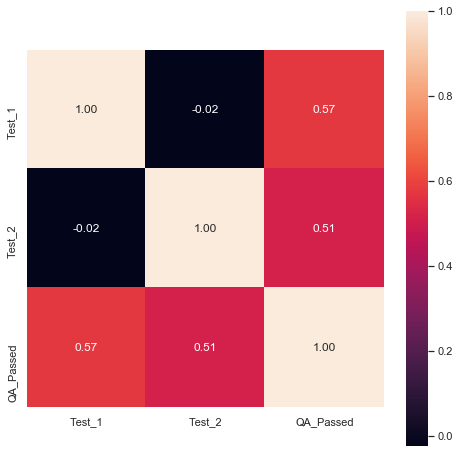

In [8]:
# Plot the correlation between features as a heatmap.
PlotHeatMap(microChipData)

As we can infer from the above heatmap, there is some correlation between Test_1, Test_2 & QA_Passed.

### Exploratory Data Analysis

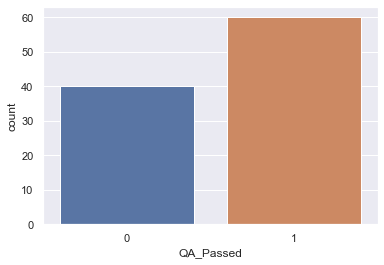

In [9]:
sns.countplot(x="QA_Passed", data=microChipData)
plt.show()

In [10]:
def plotData(X, y) -> plt.axes:

    fig = plt.figure()
    ax = fig.add_subplot()

    pos = np.argwhere(y == 1)
    neg = np.argwhere(y == 0)

    ax.scatter(X[neg, 0], X[neg, 1], c="yellow", marker='o', edgecolor="black", linewidth=0.5)
    ax.scatter(X[pos, 0], X[pos, 1], c="black", marker='+')
    ax.set_xlabel("Microchip Test 1")
    ax.set_ylabel("Microchip Test 2")
    plt.legend(["y = 0", "y = 1"])
    plt.show()

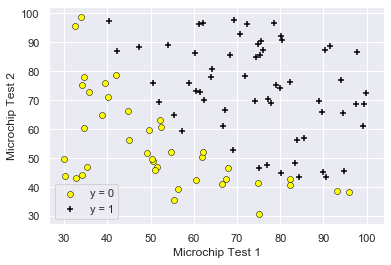

In [11]:
plotData(microChipData.iloc[:,:-1].values, microChipData.iloc[:,-1].values)

In [12]:
def FeatureTargetSplit(data):
    """
    Returns the Features of interest and targets.
        
        Parameter:
            data (DataFrame): Pandas dataframe which is to be splited into features and targets.
        
        Returns:
            features (DataFrame): Pandas dataframe consisting of the features.
            target (DataFrame): Pandas dataframe containing the target.
    """
    features = microChipData.drop("QA_Passed", axis=1)
    targets = microChipData["QA_Passed"]
    return features, targets

In [13]:
features, targets = FeatureTargetSplit(microChipData)

In [14]:
def TrainTestSplit(features, target, test_ratio=0.2, standardize=False):
    """
    Splits the features & target into respective training and test set based on the test ratio.
    
        Parameter:
            features (DataFrame): Pandas dataframe containing the features.
            target (DataFrame): Pandas dataframe containing the targets.
            test_ratio (double): Percentage of dataset to be hold out for test set. default 20%.
            standardize (bool): if True, features are scaled, default False.
            
        Returns:
            Xtrain (DataFrame): Pandas dataframe containing training features.
            Xtest (DataFrame): Pandas dataframe containing test features.
            ytrain (DataFrame): Pandas dataframe containing training targets.
            ytest (DataFrame): Pandas dataframe containing test targets.
    """
    train_len = len(features)
    train_idxs = list(range(train_len))
    np.random.shuffle(train_idxs)
    split = int(np.floor(test_ratio * train_len))
    Xtest = features.iloc[train_idxs[:split], :].values
    Xtrain = features.iloc[train_idxs[split:], :].values
    ytest = target.iloc[train_idxs[:split]].values
    ytrain = target.iloc[train_idxs[split:]].values
    if standardize:
        # Normalize Features.
        Xtrain = StandardScaler(Xtrain)
        Xtest = StandardScaler(Xtest)
    return Xtrain, Xtest, ytrain, ytest



def StandardScaler(data):
    """
    Standardize features by removing the mean and scaling to unit variance.
    
        Parameter:
            data (Dataframe): Pandas dataframe whose features must be scaled.
        
        Returns:
            data (Dataframe): Pandas dataframe with scaled features.
    """
    for col in range(data.shape[1]):
        data[:, col] = (data[:, col] - data[:,col].mean()) / (data[:,col].std())
    return data

### Train Test Split
The dataset has to be split into training and test set. Here the dataset has 100 observations and the test ratio is taken as 25% of the total observations. This indicates that the test set should have 25% * 100 = 25 observations and training set should have 75 observations respectively.

In [15]:
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(features, targets, 0.25)

### Training the Naive Bayes Classifier
Naive Bayes is a machine learning algorithm we use to solve classification problems. It is based on the Bayes Theorem. It is one of the simplest yet powerful ML algorithms and assumes that all predictors are independent.
* It assumes that every feature is independent.
* It gives every feature the same level of importance.

$ P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)} $

In [16]:
# Create and train Naive Bayes classifier.
output = mlpack.nbc(training=Xtrain, labels=ytrain)
nbc_model = output["output_model"]

### Making Predictions on Test set

In [17]:
# Predict the values for test data using previously trained model as input.
predictions = mlpack.nbc(input_model=nbc_model, test=Xtest)

In [18]:
yPreds = predictions["predictions"].reshape(-1, 1).squeeze()

### Evaluation metrics

* True Positive - The actual value was true & the model predicted true.
* False Positive - The actual value was false & the model predicted true, Type I error.
* True Negative - The actual value was false & the model predicted false.
* False Negative - The actual value was true & the model predicted false, Type II error.

`Accuracy`: is a metric that generally describes how the model performs across all classes. It is useful when all classes are of equal importance. It is calculated as the ratio between the number of correct predictions to the total number of predictions.

$$Accuracy = \frac{True_{positive} + True_{negative}}{True_{positive} + True_{negative} + False_{positive} + False_{negative}}$$

`Precision`: is calculated as the ratio between the number of positive samples correctly classified to the total number of samples classified as Positive. The precision measures the model's accuracy in classifying a sample as positive.

$$Precision = \frac{True_{positive}}{True_{positive} + False_{positive}}$$

`Recall`: is calulated as the ratio between the number of positive samples correctly classified as Positive to the total number of Positive samples. The recall measures the model's ability to detect Positive samples. The higher the recall, the more positive samples detected.

$$Recall = \frac{True_{positive}}{True_{positive} + False_{negative}}$$

* The decision of whether to use precision or recall depends on the type of problem begin solved.
* If the goal is to detect all positive samples then use recall.
* Use precision if the problem is sensitive to classifying a sample as Positive in general.

* ROC graph has the True Positive rate on the y axis and the False Positive rate on the x axis.
* ROC Area under the curve in the graph is the primary metric to determine if the classifier is doing well, the higher the value the higher the model performance.

In [19]:
def PlotRocAUC(fper, tper):
    """
    Generates a ROC AUC curve for the give True Positive Rate and False Positive Rate.
    
            Parameter:
                fper (np.ndarray): Contains the false positive rate.
                tper (np.ndarray): Contains the true positive rate.
            
            Returns:
                None
    """
    plt.plot(fper, tper, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
def modelEval(ytest, yPreds):
    print(f"Accuracy: {accuracy_score(ytest, yPreds)}")
    print(f"ROC AUC: {roc_auc_score(ytest, yPreds)}")
    print(f"Cohen's Kappa: {cohen_kappa_score(ytest, yPreds)}")
    print(classification_report(ytest,yPreds))
    fper, tper, thresh = roc_curve(ytest, predictions["probabilities"][:, 1])
    PlotRocAUC(fper, tper)

### Model Evaluation

Accuracy: 0.92
ROC AUC: 0.9166666666666667
Cohen's Kappa: 0.8387096774193549
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.87      1.00      0.93        13

    accuracy                           0.92        25
   macro avg       0.93      0.92      0.92        25
weighted avg       0.93      0.92      0.92        25



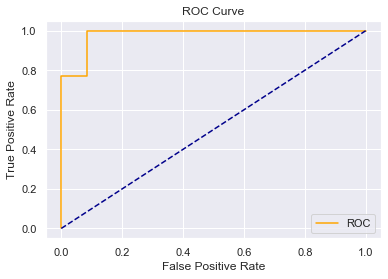

In [20]:
modelEval(ytest, yPreds)

### Conclusion
From the above classification report & a ROC AUC, we can infer that our Naive Bayes Classifier model kinda performs well on our micro chip QA. Feel free to play around with h-params, split ratio etc.